In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image 
from scipy import ndimage, misc
import matplotlib.pyplot as plt

# from image_feature_extractor import Img2Vec
from simclr_feature_extractor import get_features, train_model, create_data_loaders_from_arrays

from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing

# import seaborn as sns

from scipy.ndimage import gaussian_filter

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Useful functions and classes

In [3]:
def apply_contrast(images_data, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images_data]
    images = torch.stack(images_list)
    contrasted_images = F.adjust_contrast(images, contrast_factor)
    contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in contrasted_images]))
    return contrasted_images

def apply_rotation(images_data, angle=30):
    rotated_images = []
    for img in images_data:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        rotated_images.append(rotated_image)
    rotated_images = np.array(rotated_images)
    return rotated_images

def blur_images(images_data, sigma=1):
    blurred_images = []
    for img in images_data:
        blurred_image = gaussian_filter(img, sigma)
        blurred_images.append(blurred_image)
    blurred_images = np.array(blurred_images)
    return blurred_images


# Generate a list of original and duplicate modified images: every original image has a duplicate which is 
# the modified original image.
def generate_list_of_original_and_its_duplicate_modified_images(image_set, mod_factor, mod_type="contrast"):
    original_labels = np.zeros(len(image_set.data))
    modified_labels = np.ones(len(image_set.data))
    
    modified_images = None
    
    if mod_type=="contrast":
        modified_images = apply_contrast(image_set.data, mod_factor) 
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(image_set.data, mod_factor)
    
    elif mod_type=="blur":
        modified_images = blur_images(image_set.data, mod_factor)

    original_and_modified_images = np.concatenate((image_set.data, modified_images), axis=0)
    modification_labels = np.concatenate((original_labels, modified_labels), axis=None)
    image_labels = np.concatenate((image_set.targets, image_set.targets), axis=None)        
    return modified_images, original_and_modified_images, modification_labels, image_labels



# Generate a list of original and copies of its modified images combined: every original image has other 
# copies of itself on which different types of transformations/modifications have been applied. 
def generate_list_of_original_and_copies_of_its_modified_images(image_set, contrast_factor=0.3, angle=30, sigma=1):
    original_labels = np.zeros(len(image_set.data))
    modified_labels1 = np.ones(len(image_set.data))
    modified_labels2 = np.array([2]*len(image_set.data))
    modified_labels3 = np.array([3]*len(image_set.data))

    modified_images1 = apply_contrast(image_set.data, contrast_factor) 

    modified_images2 = apply_rotation(image_set.data, angle)
    
    modified_images3 = blur_images(image_set.data, sigma)

    original_and_modified_images = np.concatenate((image_set.data, modified_images1, modified_images2,modified_images3), axis=0)
    modification_labels = np.concatenate((original_labels, modified_labels1, modified_labels2,modified_labels3), axis=None)
    image_labels = np.concatenate((image_set.targets, image_set.targets, image_set.targets,image_set.targets), axis=None)        
    return original_and_modified_images, modification_labels, image_labels




# used to binarize the target variable
def binarize(y):    
    y = np.copy(y) > 5
    return y.astype(int)

def correlate_label_with_img_modification(image_dataset, mod_factor, mod_percent= 0.1, 
                                          binarize_label=True, mod_type="contrast"):
    y = binarize(image_dataset.targets)
    mod_labels = np.logical_xor(y, np.random.binomial(1, mod_percent, size=len(y)))
    
    images_to_be_modified = image_dataset.data[mod_labels]
    images_to_be_left_alone = image_dataset.data[~mod_labels]
    
    all_img_labels = None
    
    if binarize_label:
        modified_imgs_labels = y[mod_labels]
        unmodified_imgs_labels = y[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)
    else:
        modified_imgs_labels = np.array(image_dataset.targets)[mod_labels]
        unmodified_imgs_labels = np.array(image_dataset.targets)[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)    
    
    all_images = None
    
    if mod_type == "contrast":
        modified_images = apply_contrast(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)                    
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)
        
    return all_images, all_img_labels, mod_labels.astype(int)


# # Function to extract image features    
# def get_features(images, batch_size):
#     Z_list = []
# #     img2vec = Img2Vec(model="resnet50")
#     img2vec = Img2Vec()
#     for first in range(0, len(images), batch_size):
#         images_subset = images[first:first+batch_size]
#         Z_subset = img2vec.get_vec(images_subset)
#         Z_list.append(Z_subset)
#     Z = np.vstack(Z_list)
#     return Z


class Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, images, labels):
        #'Initialization'
        self.labels = labels
        self.images = images

    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        #'Generates one sample of data'
        # Load data and get label
        X = self.images[index]
        y = self.labels[index]

        return X, y

# Visualize Blurred Image. Change sigma value to increase or decrease blur strength

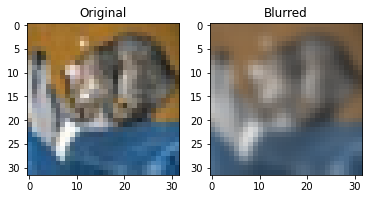

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  
ax1.set_title("Original")
ax2 = fig.add_subplot(122) 
ax2.set_title("Blurred")
img = test_dataset.data[0]
blurred = gaussian_filter(img, sigma=1)
ax1.imshow(img)
ax2.imshow(blurred)
plt.show()

In [5]:
contrast_factor = 0.3
angle = 45
sigma = 1
batch_size = 64
dist_value = 1.0

# Creating a set of images to be used to obtain L
all_images, mod_labels, img_labels = generate_list_of_original_and_copies_of_its_modified_images(
    train_dataset, contrast_factor, angle, sigma)


# Creating sets of images in a way that correlates the way images are modified with label
train_imgs, train_labels2, train_mod_labels2 = correlate_label_with_img_modification(
    train_dataset, contrast_factor, mod_percent= dist_value, binarize_label=False, mod_type="contrast")

test_imgs_indist, test_labels2_indist, test_mod_labels2_indist = correlate_label_with_img_modification(
    test_dataset, contrast_factor, mod_percent= dist_value, binarize_label=False, mod_type="contrast")

test_imgs_ood, test_labels2_ood, test_mod_labels2_ood = correlate_label_with_img_modification(
    test_dataset, contrast_factor, mod_percent= 1-dist_value, binarize_label=False, mod_type="contrast")

# creating duplicates of contrasted and uncontrasted images
t_contr_imgs, t_imgs, t_mod_labels, t_labels = generate_list_of_original_and_its_duplicate_modified_images(
    test_dataset, contrast_factor,mod_type="contrast")





print(all_images.shape)
print(train_imgs.shape)

(200000, 32, 32, 3)
(50000, 32, 32, 3)


# Extract Image Features

In [6]:
# # mod_labels[mod_labels==3]

# # Extract image features
# Z = get_features(all_images, batch_size)
# Z_train = get_features(train_imgs, batch_size)
# Z_test_indist= get_features(test_imgs_indist, batch_size)
# Z_test_ood= get_features(test_imgs_ood, batch_size)

# Z_test_original = get_features(test_dataset.data, batch_size)
# Z_test_contrasted = get_features(t_contr_imgs, batch_size)
# Z_test_og_contrasted = get_features(t_imgs, batch_size)

# mod_labels


In [7]:
import os
import torch
import numpy as np

import torchvision
import argparse

from torch.utils.tensorboard import SummaryWriter

apex = False
try:
    from apex import amp
    apex = True
except ImportError:
    print(
        "Install the apex package from https://www.github.com/nvidia/apex to use fp16 for training"
    )

from model import save_model, load_optimizer
from simclr import SimCLR
from simclr.modules import get_resnet, NT_Xent
from simclr.modules.transformations import TransformsSimCLR

Install the apex package from https://www.github.com/nvidia/apex to use fp16 for training


In [8]:
from pprint import pprint
import argparse
from utils import yaml_config_hook

parser = argparse.ArgumentParser(description="SimCLR")
config = yaml_config_hook("./config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))

args = parser.parse_args([])
# args.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
args.device = torch.device("cpu")

### override any configuration parameters here, e.g. to adjust for use on GPUs on the Colab platform:
args.batch_size = 64
args.resnet = "resnet18"
args.epoch_num = 100
args.epochs = 100
pprint(vars(args))

{'batch_size': 64,
 'dataparallel': 0,
 'dataset': 'CIFAR10',
 'dataset_dir': './datasets',
 'device': device(type='cpu'),
 'epoch_num': 100,
 'epochs': 100,
 'gpus': 1,
 'image_size': 224,
 'logistic_batch_size': 256,
 'logistic_epochs': 1000,
 'model_path': 'save',
 'nodes': 1,
 'nr': 0,
 'optimizer': 'Adam',
 'pretrain': True,
 'projection_dim': 64,
 'reload': False,
 'resnet': 'resnet18',
 'seed': 42,
 'start_epoch': 0,
 'temperature': 0.5,
 'weight_decay': 1e-06,
 'workers': 8}


In [9]:
# training_set = Dataset(t_imgs, t_labels)
# train_loader = torch.utils.data.DataLoader(
#     training_set,
#     batch_size=args.batch_size,
#     shuffle=False)

# test_loader = torch.utils.data.DataLoader(
#     training_set,
#     batch_size=args.batch_size,
#     shuffle=False)


# train_loader, test_loader = create_data_loaders_from_arrays(
#     t_imgs, t_labels, t_imgs, t_imgs, args.logistic_batch_size
# )




encoder = get_resnet(args.resnet, pretrained=False) # don't load a pre-trained model from PyTorch repo
n_features = encoder.fc.in_features  # get dimensions of fc layer

# load pre-trained model from checkpoint
simclr_model = SimCLR(encoder, args.projection_dim, n_features)
model_fp = './save/checkpoint_100.tar'

simclr_model.load_state_dict(torch.load(model_fp, map_location=args.device.type))
simclr_model = simclr_model.to(args.device)

# print("### Creating features from pre-trained context model ###")

# train_X = get_features(t_imgs, simclr_model, args.batch_size, args.device)


In [10]:
# print("### Creating features from SimCLR Model pre-trained on CIFAR10 ###")
# # Extract image features
# Z = get_features(all_images, simclr_model, args.batch_size, args.device)
# Z_train = get_features(train_imgs, simclr_model, args.batch_size, args.device)
# Z_test_indist= get_features(test_imgs_indist, simclr_model, args.batch_size, args.device)
# Z_test_ood= get_features(test_imgs_ood, simclr_model, args.batch_size, args.device)

# Z_test_original = get_features(test_dataset.data, simclr_model, args.batch_size, args.device)
# Z_test_contrasted = get_features(t_contr_imgs, simclr_model, args.batch_size, args.device)
# Z_test_og_contrasted = get_features(t_imgs, simclr_model, args.batch_size, args.device)



In [11]:
# from numpy import save
# save('Z.npy', Z)
# save('Z_train.npy', Z_train)
# save('Z_test_indist.npy', Z_test_indist)
# save('Z_test_ood.npy', Z_test_ood)
# save('Z_test_original.npy', Z_test_original)
# save('Z_test_contrasted.npy', Z_test_contrasted)
# save('Z_test_og_contrasted.npy', Z_test_og_contrasted)


In [12]:
from numpy import load
# load array
Z = load('Z.npy')
Z_train = load('Z_train.npy')
Z_test_indist = load('Z_test_indist.npy')
Z_test_ood = load('Z_test_ood.npy')
Z_test_original = load('Z_test_original.npy')
Z_test_contrasted = load('Z_test_contrasted.npy')
Z_test_og_contrasted = load('Z_test_og_contrasted.npy')

Z_test_og_contrasted.shape

(20000, 512)

# Obtaining prediction coefficients and prediction accuracy of transformations done on images

In [13]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

# not_1_and_2 = (mod_labels !=1) & (mod_labels !=2) # 0 (original) and 3 (blurred)
# not_1_and_3 = (mod_labels !=1) & (mod_labels !=3) # 0 (original) and 2 (rotated)
not_2_and_3 = (mod_labels !=2) & (mod_labels !=3) # 0 (original) and 1 (contrasted)

# Z_og_blurred = Z[not_1_and_2]
# blur_labels = mod_labels[not_1_and_2]

# Z_og_rotated = Z[not_1_and_3]
# rotation_labels = mod_labels[not_1_and_3]

Z_og_contrasted = Z[not_2_and_3]
contrast_labels =  mod_labels[not_2_and_3]



lr_model_contrast = LogisticRegression(random_state=0).fit(Z_og_contrasted, contrast_labels)
contrast_coefficients = lr_model_contrast.coef_.reshape(-1,1)
theta_1 = contrast_coefficients / np.linalg.norm(contrast_coefficients)

print("Contrast coefficients shape")
print(theta_1.shape)

print('Train Contrast prediction accuracy: ', lr_model_contrast.score(Z_og_contrasted, contrast_labels))
print('Test Contrast prediction accuracy: ', lr_model_contrast.score(Z_test_og_contrasted, t_mod_labels))


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Contrast coefficients shape
(512, 1)
Train Contrast prediction accuracy:  0.64726
Test Contrast prediction accuracy:  0.64175


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [14]:
# Classification and recording prediction accuracy
logistic_regression_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                                max_iter=100000, random_state=0).fit(Z_train,
                                                                                     train_labels2)
accuracy0 = logistic_regression_model2.score(Z_train, train_labels2)
accuracy1 = logistic_regression_model2.score(Z_test_indist, test_labels2_indist)
accuracy2 = logistic_regression_model2.score(Z_test_ood, test_labels2_ood)
print('LR Training Accuracy: ', accuracy0)
print('LR Accuracy on test data - Z - In Dist: ', accuracy1)
print('LR Accuracy on test data - Z - OOD: ', accuracy2)


LR Training Accuracy:  0.90022
LR Accuracy on test data - Z - In Dist:  0.8683
LR Accuracy on test data - Z - OOD:  0.8616


# Find L, get F features, plot histograms and perform predictions

Results for lamda  0.001

Histogram for F Test feature  0


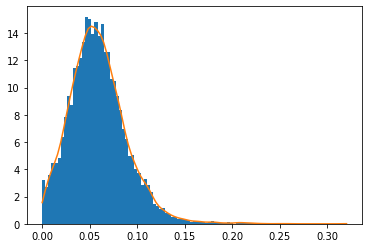

Histogram for F Test feature  1


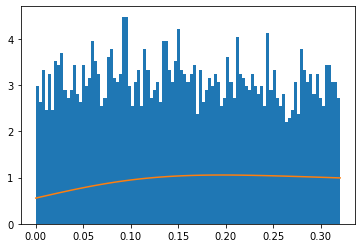

Histogram for F Test feature  2


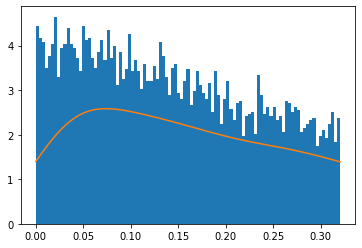

Histogram for F Test feature  3


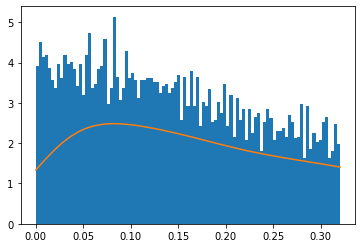

Histogram for F Test feature  4


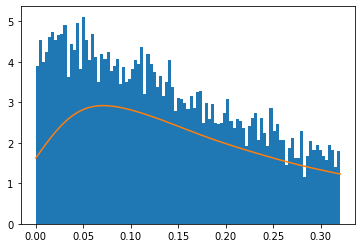

Histogram for F Test feature  5


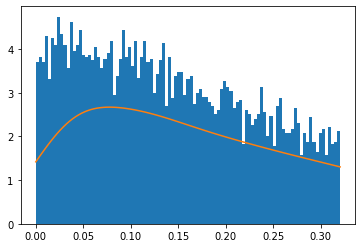

Histogram for F Test feature  6


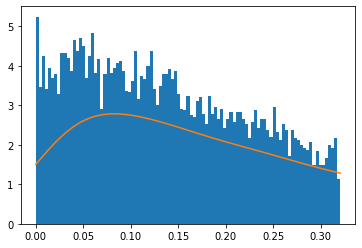

Histogram for F Test feature  7


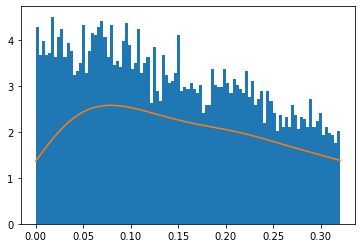

Histogram for F Test feature  8


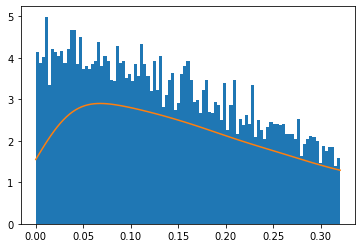

Histogram for F Test feature  9


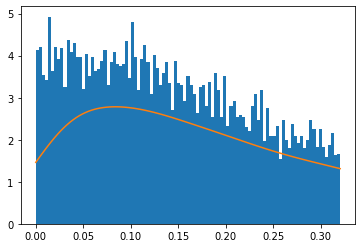

LR Training Accuracy - F:  0.88256
LR Accuracy on test data - F - In Dist:  0.8637
LR Accuracy on test data - F - OOD:  0.8528



Accuracy for without F feature  0
LR Training Accuracy - F:  0.88182
LR Accuracy on test data - F - In Dist:  0.8613
LR Accuracy on test data - F - OOD:  0.8551


Accuracy for without F feature  1
LR Training Accuracy - F:  0.88274
LR Accuracy on test data - F - In Dist:  0.863
LR Accuracy on test data - F - OOD:  0.8518


Accuracy for without F feature  2
LR Training Accuracy - F:  0.87354
LR Accuracy on test data - F - In Dist:  0.8539
LR Accuracy on test data - F - OOD:  0.8439


Accuracy for without F feature  3
LR Training Accuracy - F:  0.88068
LR Accuracy on test data - F - In Dist:  0.8599
LR Accuracy on test data - F - OOD:  0.8502


Accuracy for without F feature  4
LR Training Accuracy - F:  0.8793
LR Accuracy on test data - F - In Dist:  0.8585
LR Accuracy on test data - F - OOD:  0.8501









Results for lamda  0.01

Histogram for F Test feat

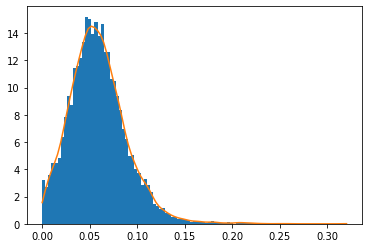

Histogram for F Test feature  1


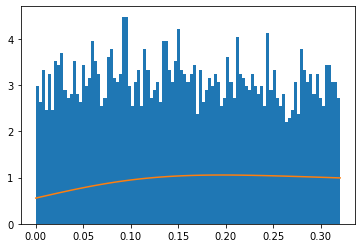

Histogram for F Test feature  2


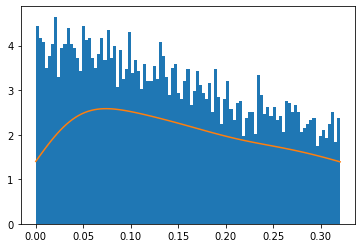

Histogram for F Test feature  3


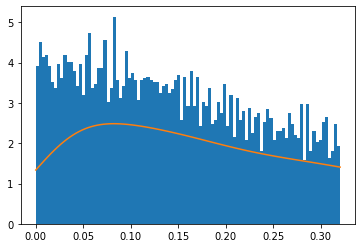

Histogram for F Test feature  4


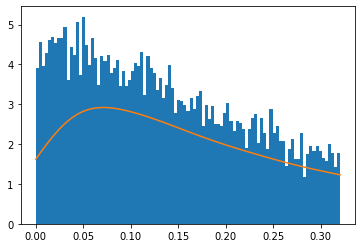

Histogram for F Test feature  5


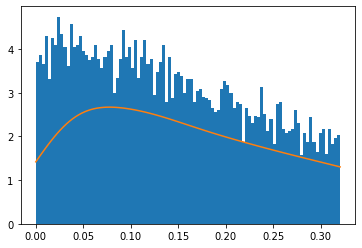

Histogram for F Test feature  6


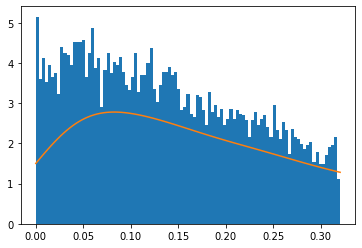

Histogram for F Test feature  7


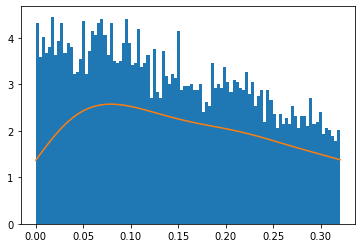

Histogram for F Test feature  8


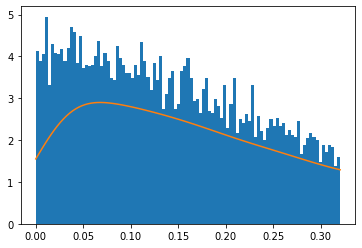

Histogram for F Test feature  9


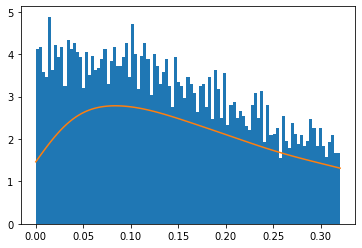

LR Training Accuracy - F:  0.88258
LR Accuracy on test data - F - In Dist:  0.8639
LR Accuracy on test data - F - OOD:  0.853



Accuracy for without F feature  0
LR Training Accuracy - F:  0.88182
LR Accuracy on test data - F - In Dist:  0.8613
LR Accuracy on test data - F - OOD:  0.8551


Accuracy for without F feature  1
LR Training Accuracy - F:  0.88266
LR Accuracy on test data - F - In Dist:  0.863
LR Accuracy on test data - F - OOD:  0.8518


Accuracy for without F feature  2
LR Training Accuracy - F:  0.87356
LR Accuracy on test data - F - In Dist:  0.8539
LR Accuracy on test data - F - OOD:  0.8438


Accuracy for without F feature  3
LR Training Accuracy - F:  0.88064
LR Accuracy on test data - F - In Dist:  0.8599
LR Accuracy on test data - F - OOD:  0.8502


Accuracy for without F feature  4
LR Training Accuracy - F:  0.87928
LR Accuracy on test data - F - In Dist:  0.8585
LR Accuracy on test data - F - OOD:  0.8501









Results for lamda  10

Histogram for F Test featur

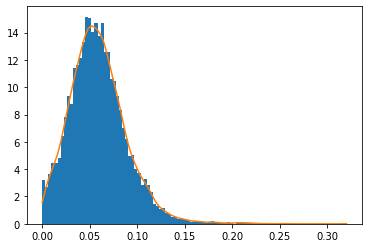

Histogram for F Test feature  1


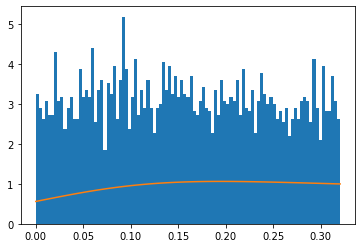

Histogram for F Test feature  2


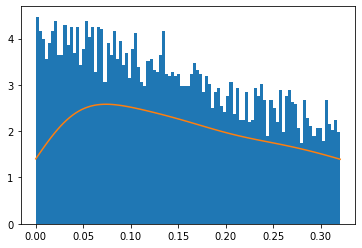

Histogram for F Test feature  3


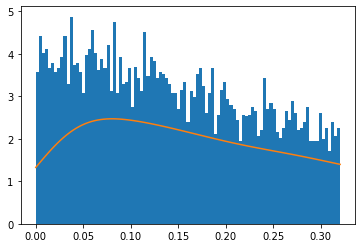

Histogram for F Test feature  4


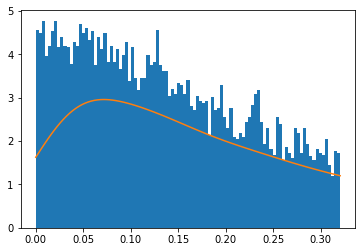

Histogram for F Test feature  5


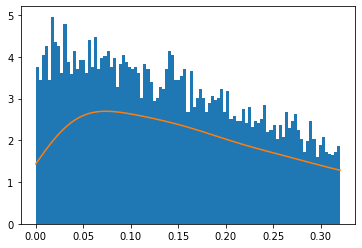

Histogram for F Test feature  6


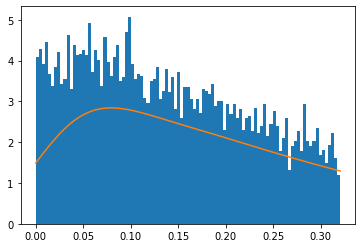

Histogram for F Test feature  7


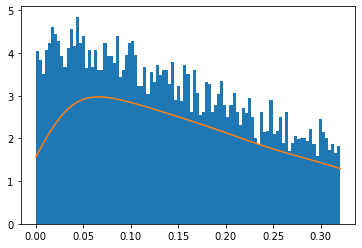

Histogram for F Test feature  8


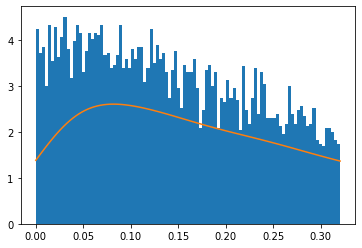

Histogram for F Test feature  9


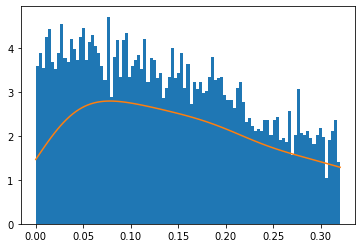

LR Training Accuracy - F:  0.8808
LR Accuracy on test data - F - In Dist:  0.8652
LR Accuracy on test data - F - OOD:  0.8514



Accuracy for without F feature  0
LR Training Accuracy - F:  0.87926
LR Accuracy on test data - F - In Dist:  0.8614
LR Accuracy on test data - F - OOD:  0.852


Accuracy for without F feature  1
LR Training Accuracy - F:  0.8809
LR Accuracy on test data - F - In Dist:  0.8637
LR Accuracy on test data - F - OOD:  0.8491


Accuracy for without F feature  2
LR Training Accuracy - F:  0.86896
LR Accuracy on test data - F - In Dist:  0.8506
LR Accuracy on test data - F - OOD:  0.8384


Accuracy for without F feature  3
LR Training Accuracy - F:  0.87862
LR Accuracy on test data - F - In Dist:  0.862
LR Accuracy on test data - F - OOD:  0.8495


Accuracy for without F feature  4
LR Training Accuracy - F:  0.87606
LR Accuracy on test data - F - In Dist:  0.8592
LR Accuracy on test data - F - OOD:  0.8442









Results for lamda  100

Histogram for F Test feature

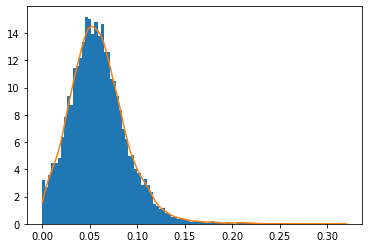

Histogram for F Test feature  1


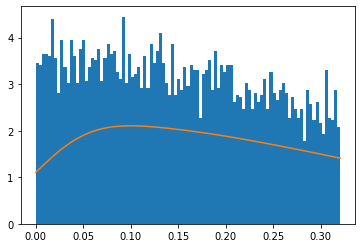

Histogram for F Test feature  2


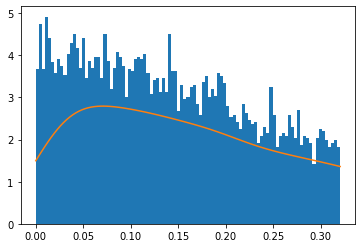

Histogram for F Test feature  3


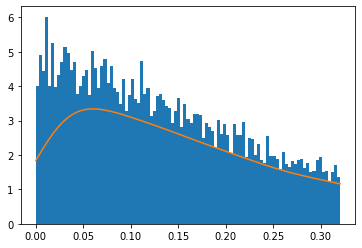

Histogram for F Test feature  4


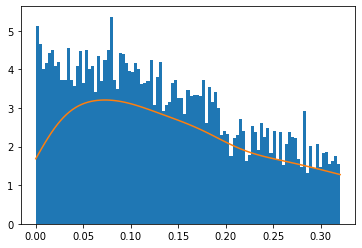

Histogram for F Test feature  5


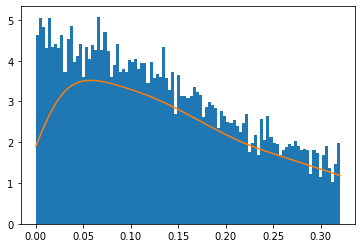

Histogram for F Test feature  6


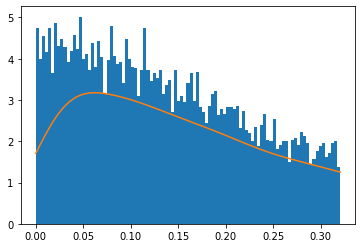

Histogram for F Test feature  7


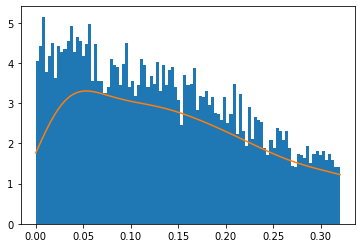

Histogram for F Test feature  8


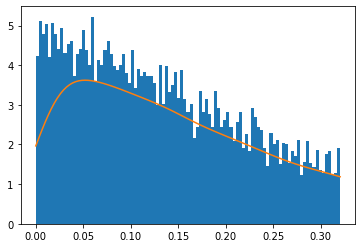

Histogram for F Test feature  9


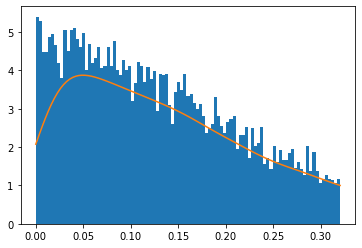

LR Training Accuracy - F:  0.87386
LR Accuracy on test data - F - In Dist:  0.853
LR Accuracy on test data - F - OOD:  0.8388



Accuracy for without F feature  0
LR Training Accuracy - F:  0.87194
LR Accuracy on test data - F - In Dist:  0.8509
LR Accuracy on test data - F - OOD:  0.843


Accuracy for without F feature  1
LR Training Accuracy - F:  0.8731
LR Accuracy on test data - F - In Dist:  0.8524
LR Accuracy on test data - F - OOD:  0.8383


Accuracy for without F feature  2
LR Training Accuracy - F:  0.86012
LR Accuracy on test data - F - In Dist:  0.8406
LR Accuracy on test data - F - OOD:  0.8248


Accuracy for without F feature  3
LR Training Accuracy - F:  0.8691
LR Accuracy on test data - F - In Dist:  0.8493
LR Accuracy on test data - F - OOD:  0.8352


Accuracy for without F feature  4
LR Training Accuracy - F:  0.86794
LR Accuracy on test data - F - In Dist:  0.8439
LR Accuracy on test data - F - OOD:  0.8287









Results for lamda  1000

Histogram for F Test featur

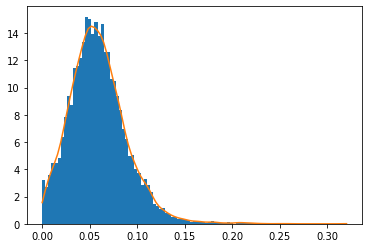

Histogram for F Test feature  1


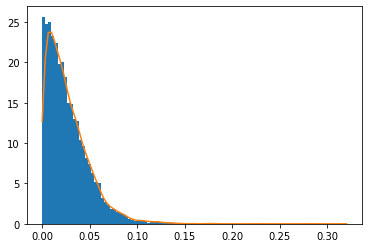

Histogram for F Test feature  2


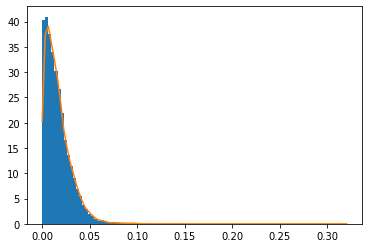

Histogram for F Test feature  3


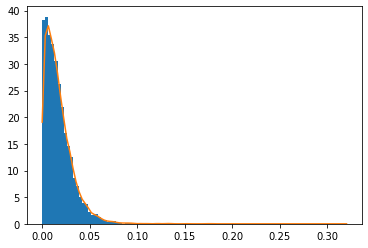

Histogram for F Test feature  4


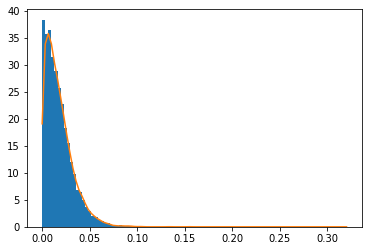

Histogram for F Test feature  5


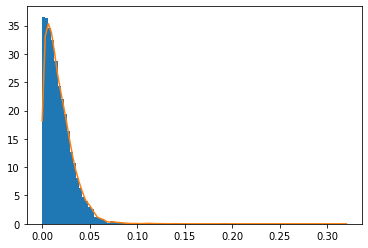

Histogram for F Test feature  6


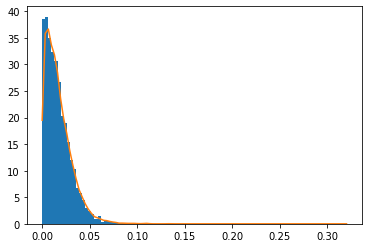

Histogram for F Test feature  7


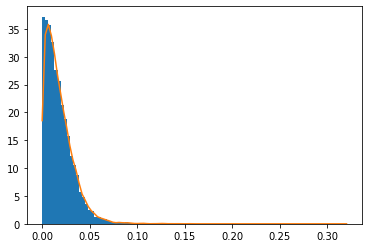

Histogram for F Test feature  8


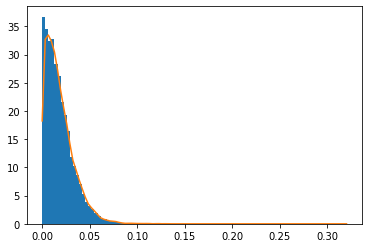

Histogram for F Test feature  9


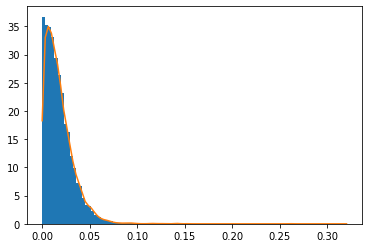

LR Training Accuracy - F:  0.82926
LR Accuracy on test data - F - In Dist:  0.8097
LR Accuracy on test data - F - OOD:  0.7829



Accuracy for without F feature  0
LR Training Accuracy - F:  0.8244
LR Accuracy on test data - F - In Dist:  0.8074
LR Accuracy on test data - F - OOD:  0.7978


Accuracy for without F feature  1
LR Training Accuracy - F:  0.82758
LR Accuracy on test data - F - In Dist:  0.8088
LR Accuracy on test data - F - OOD:  0.7809


Accuracy for without F feature  2
LR Training Accuracy - F:  0.82886
LR Accuracy on test data - F - In Dist:  0.8104
LR Accuracy on test data - F - OOD:  0.782


Accuracy for without F feature  3
LR Training Accuracy - F:  0.82942
LR Accuracy on test data - F - In Dist:  0.8103
LR Accuracy on test data - F - OOD:  0.783


Accuracy for without F feature  4
LR Training Accuracy - F:  0.8288
LR Accuracy on test data - F - In Dist:  0.8106
LR Accuracy on test data - F - OOD:  0.7823









Results for lamda  100000

Histogram for F Test feat

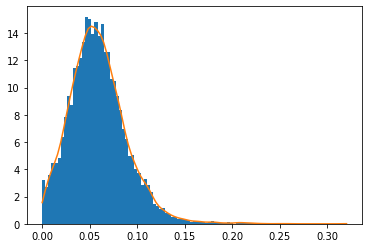

Histogram for F Test feature  1


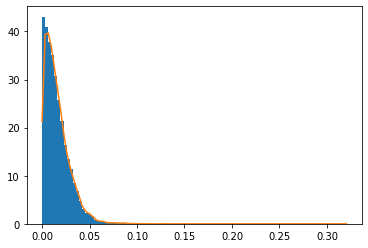

Histogram for F Test feature  2


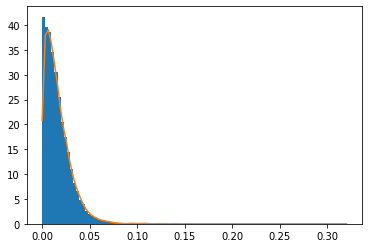

Histogram for F Test feature  3


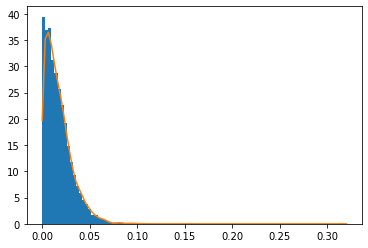

Histogram for F Test feature  4


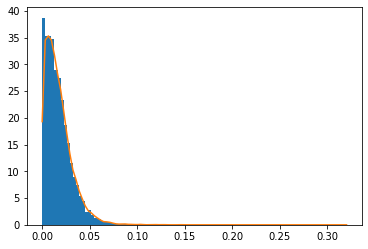

Histogram for F Test feature  5


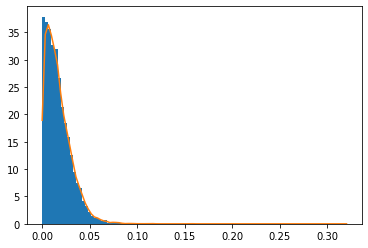

Histogram for F Test feature  6


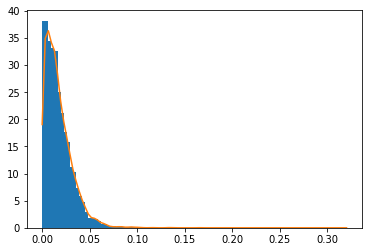

Histogram for F Test feature  7


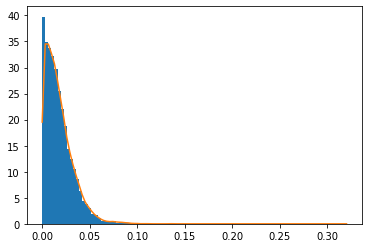

Histogram for F Test feature  8


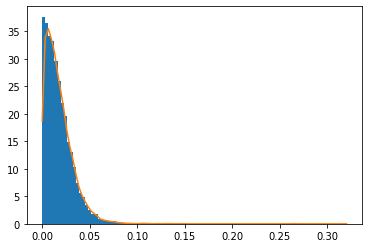

Histogram for F Test feature  9


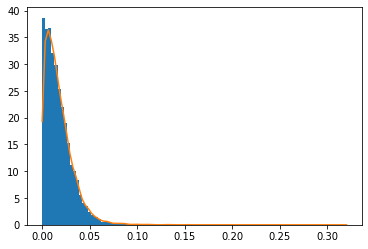

LR Training Accuracy - F:  0.81638
LR Accuracy on test data - F - In Dist:  0.7993
LR Accuracy on test data - F - OOD:  0.7653



Accuracy for without F feature  0
LR Training Accuracy - F:  0.81144
LR Accuracy on test data - F - In Dist:  0.7933
LR Accuracy on test data - F - OOD:  0.7812


Accuracy for without F feature  1
LR Training Accuracy - F:  0.81574
LR Accuracy on test data - F - In Dist:  0.7971
LR Accuracy on test data - F - OOD:  0.7634


Accuracy for without F feature  2
LR Training Accuracy - F:  0.81606
LR Accuracy on test data - F - In Dist:  0.7996
LR Accuracy on test data - F - OOD:  0.7665


Accuracy for without F feature  3
LR Training Accuracy - F:  0.81614
LR Accuracy on test data - F - In Dist:  0.7989
LR Accuracy on test data - F - OOD:  0.765


Accuracy for without F feature  4
LR Training Accuracy - F:  0.81584
LR Accuracy on test data - F - In Dist:  0.798
LR Accuracy on test data - F - OOD:  0.7655











In [15]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [0.001,0.01,10,100,1000,100000]

for lamda in lamdas:
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.5) # % of original number of features
    n = Z.shape[0]
    
    delta_Z_matrix1 = np.absolute((Z_og_contrasted[:int(len(Z_og_contrasted)/2),:] - Z_og_contrasted[int(len(Z_og_contrasted)/2):,:]))
   
    M = - Z.T @ Z/n + lamda * delta_Z_matrix1.T @ delta_Z_matrix1 / (n // 2 ) 

    # Computing the term on which we perform SVD
    theta_1_theta_1_T = theta_1 @ theta_1.T
    d = theta_1_theta_1_T.shape[0]
    I = np.identity(d)
    I_minus_theta_1_theta_1_T = I-theta_1_theta_1_T
    term_for_SVD = (I_minus_theta_1_theta_1_T @ M) @ I_minus_theta_1_theta_1_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)

    # Forming L from eigenvectors and coeficients of transformations 
    L_1 = theta_1
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]

    L_2 = eigenvectors[:,non_zero_indeces]

    L = np.concatenate((L_1,L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_train = torch.from_numpy(np.linalg.lstsq(L, Z_train.transpose(), rcond=None)[0].transpose())
    F_test_indist = torch.from_numpy(np.linalg.lstsq(L, Z_test_indist.transpose(), rcond=None)[0].transpose())
    F_test_ood = torch.from_numpy(np.linalg.lstsq(L, Z_test_ood.transpose(), rcond=None)[0].transpose())
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_contrasted = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrasted.transpose(), rcond=None)[0].transpose())
    

    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_contrasted.detach().numpy())
    delta_matrix_df = pd.DataFrame(delta_matrix)

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(10): #(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
    
    
    # Classification task using F features    
    lr_model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000, random_state=0).fit(F_train,train_labels2)
    accuracy0 = lr_model1.score(F_train, train_labels2)
    accuracy1 = lr_model1.score(F_test_indist, test_labels2_indist)
    accuracy2 = lr_model1.score(F_test_ood, test_labels2_ood)
    print('LR Training Accuracy - F: ', accuracy0)
    print('LR Accuracy on test data - F - In Dist: ', accuracy1)
    print('LR Accuracy on test data - F - OOD: ', accuracy2)
    print("\n"*2)

    # Removing one feature at a time
    for i in range(5): #(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without F feature ",i)

        X_train = F_train.detach().numpy().copy()
        X_test_indist = F_test_indist.detach().numpy().copy()
        X_test_ood = F_test_ood.detach().numpy().copy()

        X_train = np.delete(X_train, i, 1)
        X_test_indist = np.delete(X_test_indist, i, 1)
        X_test_ood = np.delete(X_test_ood, i, 1)
       

        lr_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000, random_state=0).fit(X_train,train_labels2)
        accuracy0 = lr_model2.score(X_train, train_labels2)
        accuracy1 = lr_model2.score(X_test_indist, test_labels2_indist)
        accuracy2 = lr_model2.score(X_test_ood, test_labels2_ood)
        print('LR Training Accuracy - F: ', accuracy0)
        print('LR Accuracy on test data - F - In Dist: ', accuracy1)
        print('LR Accuracy on test data - F - OOD: ', accuracy2)

        print("\n"*1)
    print("\n"*6)


